# Clustering and Recommendations

We've made a lot of features, many of which we don't want to give equal weight. This notebook creates similarity measures for the following groupings of features:
    - metadata
    - words and sentences
    - repetition
    - profanity
    - parts of speech
    - point of view
    - sentiment
    - bag of words

## import

In [425]:
import pickle
import numpy as np
import pandas as pd
from datetime import date
import json
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize, regexp_tokenize
import gensim
from gensim.corpora.dictionary import Dictionary

import spacy
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

In [426]:
sw = stopwords.words("english")

In [427]:
with open(f'../data/metascripts_df_sentiment.pickle', 'rb') as file:
    metascripts = pickle.load(file)
    
with open(f'../data/metascripts_repetition_df.pickle', 'rb') as file:
    metascripts_rep = pickle.load(file)
    
with open('../data/cosims_df.pickle', 'rb') as file:
    bow_cosims_long = pickle.load(file)
    
with open('../data/pos_props_df.pickle', 'rb') as file:
    pos_props_df = pickle.load(file)
    
with open('../data/pos_props_df.pickle', 'rb') as file:
    pos_props_df = pickle.load(file)
    
with open('../data/pov_props_relative_df.pickle', 'rb') as file:
    pov_props_df = pickle.load(file)

## prepare the data for unsupervised learning

### bow cosims
Widen the bag-of-words cosims dataframe in preparation for later steps

In [428]:
bow_cosims = bow_cosims_long.pivot(index = 'show', columns = 'other_show')
bow_cosims.columns = bow_cosims.columns.droplevel(0)
bow_cosims.head(3)

other_show,ADEL KARAM: LIVE FROM BEIRUT (2018) – Full Transcript,AL MADRIGAL: WHY IS THE RABBIT CRYING? (2013) – Full Transcript,ALI WONG: BABY COBRA (2016) – Full Transcript,AMY SCHUMER: LIVE AT THE APOLLO (2015) – Full Transcript,AMY SCHUMER: MOSTLY SEX STUFF (2012) – Full Transcript,AMY SCHUMER: THE LEATHER SPECIAL (2017) – Full Transcript,ANTHONY JESELNIK: CALIGULA (2013) – Full Transcript,ARI SHAFFIR: DOUBLE NEGATIVE (2017) – Full Transcript,AZIZ ANSARI: BURIED ALIVE (2013) – Full Transcript,AZIZ ANSARI: INTIMATE MOMENTS FOR A SENSUAL EVENING (2010) – Full Transcript,...,Trevor Noah: Lost In Translation (2015) – Transcript,Trevor Noah: Son of Patricia (2018) – Transcript,URZILA CARLSON: OVERQUALIFIED LOSER (2020) – FULL TRANSCRIPT,Vir Das: Losing It (2018) – Full Transcript,Vir Das: Outside in – The Lockdown Special (2020) – Transcript,W. Kamau Bell: Private School Negro (2018) – Transcript,WHITNEY CUMMINGS: I LOVE YOU (2014) – Full Transcript,WHITNEY CUMMINGS: I’M YOUR GIRLFRIEND (2016) – Full Transcript,Wanda Sykes: Not Normal (2019) – Full Transcript,Whitney Cummings: Can I Touch It? (2019) – Full Transcript
show,,,,,,,,,,,,,,,,,,,,,
ADEL KARAM: LIVE FROM BEIRUT (2018) – Full Transcript,1.00000,0.637180,0.580570,0.472188,0.528584,0.560597,0.642047,0.610471,0.605022,0.594237,...,0.617380,0.661296,0.599753,0.580962,0.570944,0.581046,0.597501,0.567306,0.565989,0.620437
AL MADRIGAL: WHY IS THE RABBIT CRYING? (2013) – Full Transcript,0.63718,1.000000,0.712771,0.568824,0.631640,0.683177,0.727761,0.781330,0.788488,0.736362,...,0.700322,0.730040,0.747992,0.678442,0.703266,0.711836,0.698133,0.694959,0.728826,0.743366
ALI WONG: BABY COBRA (2016) – Full Transcript,0.58057,0.712771,1.000000,0.740281,0.771043,0.789783,0.710471,0.811513,0.796769,0.785096,...,0.745236,0.748159,0.753453,0.704281,0.774609,0.761718,0.780945,0.783674,0.794071,0.744459


### metadata
Dummify categorical variables and combine metadata variables into one dataframe.

In [429]:
companies_dummy = pd.get_dummies(metascripts['companies'].str.split(",").explode()).sum(level=0)
companies_dummy.head(3)

,,3 Arts Entertainment,A24,Another Mulligan Entertainment,Art & Industry,Attic Bedroom,BBC Comedy,Black Gold Films,Blue Wolf Productions,Brillstein Entertainment Partners,...,The Nacelle Company,Three T's Entertainment,Tiger Aspect Productions,Triage Entertainment,Universal Pictures,Universal Pictures UK,Universal Studios,Weirdass Comedy,What's Wrong with People?,e&a Film Berlin
0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [430]:
ratings_dummy = pd.get_dummies(metascripts['contentRating'])
ratings_dummy.head(3)

,Not Rated,PG,R,TV-14,TV-G,TV-MA,TV-PG,Unrated
0,0,0,0,1,0,0,0,0
1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0


In [431]:
meta_num_features = ['year', 'runtimeMins', 'imDbRating', 'imDbRatingVotes']

In [432]:
metadata = pd.concat([metascripts[meta_num_features], companies_dummy, ratings_dummy], axis = 1).fillna(0)

### repetition proportions
Just take the repetition proportions per show

In [433]:
repetition = metascripts_rep[['description', 'threepeat proportions']]
repetition.shape

(310, 2)

### part-of-speech proportions
These are ready for cosine similarity besides dropping SYM (symbols).

In [434]:
pos_props_df = pos_props_df.drop(columns = 'SYM')
pos_props_df.head(3)

,description,VERB,PRON,INTJ,NOUN,ADV,AUX,ADJ,PART,ADP,DET,SCONJ,CCONJ,PROPN,NUM
0,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.146510,0.184963,0.017147,0.145698,0.062906,0.106230,0.053673,0.037845,0.081981,0.077922,0.024046,0.027902,0.025974,0.007204
1,Louis C. K.: Sorry (2021) | Transcript,0.140020,0.206552,0.016381,0.133737,0.057669,0.106361,0.057556,0.039942,0.076517,0.074274,0.030405,0.029507,0.021317,0.008639
2,Drew Michael: Drew Michael (2018) | Transcript,0.136785,0.216978,0.043468,0.119326,0.058519,0.116918,0.053341,0.040698,0.083925,0.060566,0.027694,0.026851,0.007586,0.007345


### point-of-view proportions
These are also ready for cosine similarity.

In [435]:
pov_props_df.head(3)

,description,third_person,first_person,second_person
0,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.695040,0.202955,0.102005
1,Louis C. K.: Sorry (2021) | Transcript,0.718351,0.179794,0.101856
2,Drew Michael: Drew Michael (2018) | Transcript,0.614692,0.235545,0.149763


### words and sentences
Select off just the relevant word and sentence features from the metascripts dataframe.

In [436]:
ws_features = [
       'mean word length', 'std word length', 'Q1.0 word length',
       'Q2.0 word length', 'Q3.0 word length', 'max word length',
       'mean sentence length', 'std sentence length', 'Q1.0 sentence length',
       'Q2.0 sentence length', 'Q3.0 sentence length', 'max sentence length',
       'unique words', 'total words', 'proportion unique words',
       'unique words per sentence', 'words per minute', 'sentences per minute'
    ]

words_sentences = metascripts[ws_features]
words_sentences.head(3)

,mean word length,std word length,Q1.0 word length,Q2.0 word length,Q3.0 word length,max word length,mean sentence length,std sentence length,Q1.0 sentence length,Q2.0 sentence length,Q3.0 sentence length,max sentence length,unique words,total words,proportion unique words,unique words per sentence,words per minute,sentences per minute
0,3.805854,2.103520,2.0,4.0,5.0,14,8.482407,6.064443,4.0,7.0,11.0,52,1537,9771,0.157302,1.423148,130.871429,15.428571
1,3.624900,1.967809,2.0,3.0,5.0,14,11.284530,10.199352,4.0,8.0,15.0,85,1184,8787,0.134745,1.635359,129.682540,11.492063
2,3.586754,1.980245,2.0,3.0,4.0,16,8.530658,7.739877,4.0,6.0,11.0,72,1097,8259,0.132825,1.222965,127.533333,14.950000


### profanity
Select off just the relevant profanity features from the metascripts dataframe.

In [437]:
profanity_features = ['profane count', 'profane proportion', 'profanity per sentence', 'profanity per minute']
profanity = metascripts[profanity_features]
profanity.head(3)

,profane count,profane proportion,profanity per sentence,profanity per minute
0,18,0.001965,0.016667,0.257143
1,185,0.022652,0.255525,2.936508
2,79,0.010324,0.088071,1.316667


### sentiment: polarity and subjectivity
Select off just the polarity and subjectivity measures from the metascripts dataframe.

In [438]:
sentiment_features = ['polarity', 'subjectivity',
       'mean sentence polarity', 'Q1.0 sentence polarity',
       'Q2.0 sentence polarity', 'Q3.0 sentence polarity',
       'std sentence polarity', 'mean sentence subjectivity',
       'Q1.0 sentence subjectivity', 'Q2.0 sentence subjectivity',
       'Q3.0 sentence subjectivity', 'std sentence subjectivity']

sentiment = metascripts[sentiment_features]
sentiment.head(3)

,polarity,subjectivity,mean sentence polarity,Q1.0 sentence polarity,Q2.0 sentence polarity,Q3.0 sentence polarity,std sentence polarity,mean sentence subjectivity,Q1.0 sentence subjectivity,Q2.0 sentence subjectivity,Q3.0 sentence subjectivity,std sentence subjectivity
0,0.097589,0.517699,0.047180,0.0,0.0,0.069053,0.263120,0.251070,0.0,0.000000,0.5,0.334660
1,0.053696,0.561832,0.028132,0.0,0.0,0.136364,0.321037,0.321318,0.0,0.226389,0.6,0.338736
2,0.025106,0.576284,0.009020,0.0,0.0,0.000000,0.282668,0.288177,0.0,0.000000,0.6,0.346687


### collect dataframes into a dictionary

In [439]:
features_dict = {
    'metadata':metadata,
    'pos_props':pos_props_df.drop(columns = 'description'),
    'pov_props':pov_props_df.drop(columns = 'description'),
    'words_sentences':words_sentences,
    'profanity':profanity,
    'sentiment':sentiment,
    'repetition':repetition.drop(columns = 'description')
}

## cosine similarity

In [440]:
from sklearn.metrics.pairwise import cosine_similarity

In [441]:
def get_scaled_similarities(df):
    scaled = StandardScaler().fit_transform(df)
    cosims = cosine_similarity(scaled)
    df = (pd.DataFrame(index = metascripts['description'],
                                  columns = metascripts['description'],
                                  data = cosims
                    )
         )
    return df

### run get_scaled_similarities on each dataframe

In [442]:
feature_cosims_dict = {key: get_scaled_similarities(df) for key, df in tqdm(features_dict.items())}
feature_cosims_dict['bow'] = bow_cosims

  0%|          | 0/7 [00:00<?, ?it/s]

In [443]:
for key, value in feature_cosims_dict.items():
    print(key, value.shape, type(value))

metadata (310, 310) <class 'pandas.core.frame.DataFrame'>
pos_props (310, 310) <class 'pandas.core.frame.DataFrame'>
pov_props (310, 310) <class 'pandas.core.frame.DataFrame'>
words_sentences (310, 310) <class 'pandas.core.frame.DataFrame'>
profanity (310, 310) <class 'pandas.core.frame.DataFrame'>
sentiment (310, 310) <class 'pandas.core.frame.DataFrame'>
repetition (310, 310) <class 'pandas.core.frame.DataFrame'>
bow (310, 310) <class 'pandas.core.frame.DataFrame'>


In [444]:
# checking the calculations below on (i,j) = (0,1)
np.mean([df.to_numpy()[0,1] for df in feature_cosims_dict.values()])

-0.18741755228757817

In [445]:
cosims_means = np.mean([df.to_numpy() for df in feature_cosims_dict.values()], axis = 0)
cosims_means_df = pd.DataFrame(index = metascripts['description'],
                         columns = metascripts['description'],
                         data = cosims_means)
cosims_means_df.head(3)

description,Jim Gaffigan: Comedy Monster (2021) | Transcript,Louis C. K.: Sorry (2021) | Transcript,Drew Michael: Drew Michael (2018) | Transcript,Drew Michael: Red Blue Green (2021) | Transcript,Mo Amer: Mohammed in Texas (2021) | Transcript,Dave Chappelle: The Closer (2021) | Transcript,Kathleen Madigan: Bothering Jesus (2016) – Transcript,Kathleen Madigan: Madigan Again (2013) – Transcript,Phil Wang: Philly Philly Wang Wang (2021) – Transcript,Tom Papa: You’re Doing Great! (2020) – Transcript,...,Dave Chappelle: The Age of Spin (2017) – Transcript,GEORGE CARLIN: BACK IN TOWN (1996) – Full transcript,LOUIS C.K.: 2017 – Full transcript,George Carlin: Jamming in New York (1992) – Transcript,Reggie Watts: Spatial (2016) – Full Transcript,GEORGE CARLIN: COMPLAINTS AND GRIEVANCES (2001) – FULL TRANSCRIPT,GEORGE CARLIN: LIFE IS WORTH LOSING (2006) – Transcript,George Carlin: It’s Bad For Ya (2008) Full transcript,Dave Chappelle: 8:46 – Transcript,JIM JEFFERIES ON GUN CONTROL [FULL TRANSCRIPT]
description,,,,,,,,,,,,,,,,,,,,,
Jim Gaffigan: Comedy Monster (2021) | Transcript,1.000000,-0.187418,0.051541,0.235487,0.035216,-0.113008,0.193764,0.177253,0.502750,0.014002,...,-0.178831,-0.292271,-0.022739,-0.070034,-0.014805,-0.221994,-0.181535,-0.203727,0.105943,-0.192159
Louis C. K.: Sorry (2021) | Transcript,-0.187418,1.000000,0.108324,0.192108,-0.275118,0.580995,0.024935,0.034953,-0.033389,0.027170,...,0.321855,0.499201,0.184751,0.402349,-0.026892,0.155685,0.153242,0.203921,0.156735,0.347294
Drew Michael: Drew Michael (2018) | Transcript,0.051541,0.108324,1.000000,0.580078,-0.020253,0.118964,0.241776,0.528265,-0.174051,0.404041,...,-0.037459,-0.088925,-0.068119,0.008832,0.455595,-0.177821,-0.178126,-0.166148,-0.254932,0.397203


In [446]:
px.box(cosims_means_df, x = 'Reggie Watts: Spatial (2016) – Full Transcript', hover_data = [feature_cosims_df.index], points = 'all')

### make cosims_means_df long

In [447]:
cosims_means_df_long = (cosims_means_df.melt(var_name = 'other description', 
                                            value_name = 'cosine similarity', 
                                            ignore_index = False)
                                      .reset_index()
                       )
#cosims_means_df_long[cosims_means_df_long['cosine similarity'] != 1]

In [448]:
widget_df = (cosims_means_df_long
                .merge(metascripts[['description', 'fullTitle', 'artist']])
                .merge(metascripts, 
                       left_on = 'other description', 
                       right_on = 'description')
                    .rename(columns = {'description_x': 'description',
                                       'fullTitle_x': 'fullTitle',
                                       'fullTitle_y': 'other fullTitle',
                                       'artist_x': 'artist',
                                       'artist_y': 'other artist'})
                    .drop(columns = 'description_y')
        )

widget_df.head(3)

,description,other description,cosine similarity,fullTitle,artist,link,transcript,script characters,id,other artist,...,mean sentence polarity,Q1.0 sentence polarity,Q2.0 sentence polarity,Q3.0 sentence polarity,std sentence polarity,mean sentence subjectivity,Q1.0 sentence subjectivity,Q2.0 sentence subjectivity,Q3.0 sentence subjectivity,std sentence subjectivity
0,Jim Gaffigan: Comedy Monster (2021) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,1.000000,Jim Gaffigan: Comedy Monster (2021),Jim Gaffigan,https://scrapsfromtheloft.com/comedy/jim-gaffi...,"Thank you! Thank you! Oh, my gosh. Thank you s...",49799,tt15907298,Jim Gaffigan,...,0.04718,0.0,0.0,0.069053,0.26312,0.25107,0.0,0.0,0.5,0.33466
1,Louis C. K.: Sorry (2021) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,-0.187418,Sorry (2021),Louis C.K.,https://scrapsfromtheloft.com/comedy/jim-gaffi...,"Thank you! Thank you! Oh, my gosh. Thank you s...",49799,tt15907298,Jim Gaffigan,...,0.04718,0.0,0.0,0.069053,0.26312,0.25107,0.0,0.0,0.5,0.33466
2,Drew Michael: Drew Michael (2018) | Transcript,Jim Gaffigan: Comedy Monster (2021) | Transcript,0.051541,Drew Michael: Drew Michael (2018),Drew Michael,https://scrapsfromtheloft.com/comedy/jim-gaffi...,"Thank you! Thank you! Oh, my gosh. Thank you s...",49799,tt15907298,Jim Gaffigan,...,0.04718,0.0,0.0,0.069053,0.26312,0.25107,0.0,0.0,0.5,0.33466


In [449]:
widget_df['image html'] = widget_df['image'].apply(lambda x: f"<img src='{x}' width='100px'>")

In [450]:
from ipywidgets import interact
import ipywidgets
from IPython.display import Image, HTML
from random import randrange

def show_df(NewArtistsOnly, Show):
    if NewArtistsOnly:
        filtered = widget_df[(widget_df['fullTitle'] == Show) 
                             & 
                             (
                                 (widget_df['artist'] != widget_df['other artist']) 
                                 | 
                                 (widget_df['cosine similarity'] >= 0.9999999)
                             )
                            ]
        tops = filtered.nlargest(6, 'cosine similarity')
        bottom = filtered.nsmallest(1, 'cosine similarity')
        topbottom = pd.concat([tops, bottom]).reset_index()
        output_df = topbottom[['title', 'year', 'image html', 'cosine similarity']].T
        output_df.columns = ['Selection', 'Recommendation 1', 'Recommendation 2', 'Recommendation 3', 'Recommendation 4', 'Recommendation 5', 'Something Different']
        output_df.index = output_df.index.str.title()
        output = HTML(output_df.to_html(escape=False))
    else:
        filtered = widget_df[widget_df['fullTitle'] == Show]
        tops = filtered.nlargest(6, 'cosine similarity')
        bottom = filtered.nsmallest(1, 'cosine similarity')
        topbottom = pd.concat([tops, bottom]).reset_index()
        output_df = topbottom[['title', 'year', 'image html', 'cosine similarity']].T
        output_df.columns = ['Selection', 'Recommendation 1', 'Recommendation 2', 'Recommendation 3', 'Recommendation 4', 'Recommendation 5', 'Something Different']
        output_df.index = output_df.index.str.title()
        output = HTML(output_df.to_html(escape=False))
    return output

def what_should_i_watch():
    unique_show_titles = widget_df['fullTitle'].sort_values().unique()
    random_index = randrange(len(unique_show_titles))
    starting_show = unique_show_titles[random_index]
    show_selection_combobox = ipywidgets.Combobox(
                                value=starting_show,
                                placeholder='Start typing a show or artist',
                                options=list(unique_show_titles),
                                description='Select a Show',
                                ensure_option=True,
                                disabled=False
                            )
#     show_selection_widget = ipywidgets.Dropdown(
#                                     options = unique_show_titles,
#                                     value = starting_show,
#                                     description = 'Select a Show',
#                                     disabled = False,
#                                 )
    new_artists_filter_widget = ipywidgets.Checkbox(
                                    value = False,
                                    description ='Show Only Other Artists?',
                                    disabled =False,
                                )
    return interact(show_df, NewArtistsOnly = new_artists_filter_widget, Show = show_selection_combobox)

In [451]:
what_should_i_watch()

interactive(children=(Checkbox(value=False, description='Show Only Other Artists?'), Combobox(value='Ralphie M…

<function __main__.show_df(NewArtistsOnly, Show)>

## appendix

### original cosine similarity code

In [ ]:
def token_filter(token):
    return not (token.is_punct | token.is_space | token.is_stop)

filtered_tokens = []
for scripts_subset in tqdm(chunker(scripts, 2), total = np.ceil(len(scripts)/2)):
    for doc in nlp.pipe(scripts_subset):
        tokens = [token.lemma_.lower() for token in doc if token_filter(token)]
        filtered_tokens.append(tokens)
        
tokens_no_sw = [[token for token in tokenized_script if token not in sw] for tokenized_script in filtered_tokens]

scripts_counters = {description: Counter(tokenized_script) for description, tokenized_script in zip(descriptions, tokens_no_sw)}
scripts_df = pd.DataFrame.from_dict(scripts_counters, orient = 'index').fillna(0)

cosims = cosine_similarity(scripts_df)
cosims_df = (pd.DataFrame(index=scripts_df.index, 
                          columns=scripts_df.index, 
                          data = cosims)
                .melt(var_name='other_show', 
                      value_name='cosine_similarity', 
                      ignore_index=False)
                .reset_index()
                .rename(columns = {'index':'show'})
        )

### render image or thumbnail

In [ ]:
from IPython.display import Image, HTML

#HTML(metascripts.loc[:5,['image']].to_html(escape = False))
Image(url= f"{metascripts.loc[0,'image']}")

### kmeans clustering

In [33]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from jupyterthemes import jtplot
jtplot.style()

  0%|          | 0/59 [00:00<?, ?it/s]

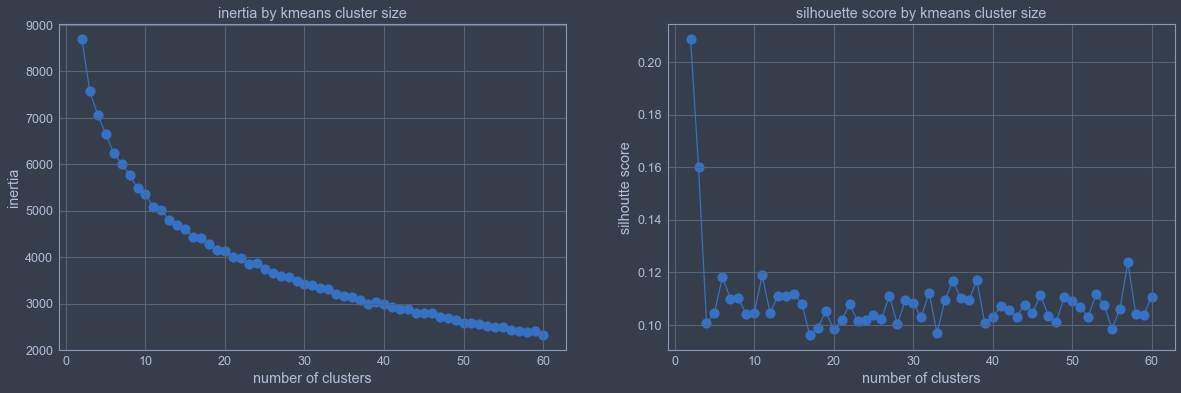

In [47]:
inertias = []
sil_scores = []
max_clusters = 60
for n_clusters in tqdm(range(2, max_clusters+1)):
    
    pipeline = Pipeline(
        steps = [
            ('scaler', StandardScaler()),
            ('cluster', KMeans(n_clusters = n_clusters))
        ]
    )

    pipeline.fit(metascripts[features])
    inertias.append(pipeline['cluster'].inertia_)

    
    features_scaled = pipeline['scaler'].transform(metascripts[features])
    features_clusters = pipeline.predict(metascripts[features])
    sil_score = silhouette_score(features_scaled, features_clusters)
    sil_scores.append(sil_score)
        
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20,6))

ax1.plot(range(2, max_clusters + 1), inertias)
ax1.scatter(range(2, max_clusters + 1), inertias, s = 100)
ax1.set_xlabel("number of clusters")
ax1.set_ylabel("inertia")
ax1.set_title("inertia by kmeans cluster size")

ax2.plot(range(2, max_clusters + 1), sil_scores)
ax2.scatter(range(2, max_clusters + 1), sil_scores, s = 100)
ax2.set_xlabel("number of clusters")
ax2.set_ylabel("silhoutte score")
ax2.set_title("silhouette score by kmeans cluster size");

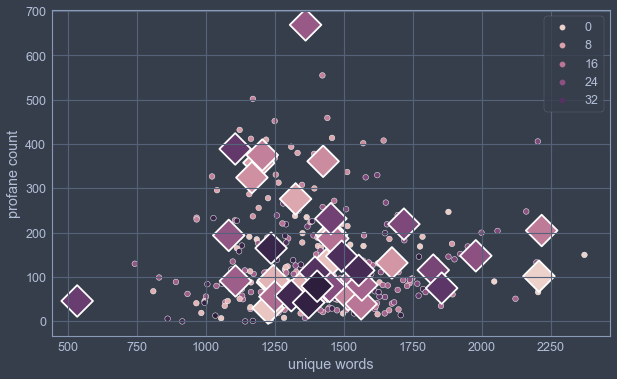

In [57]:
n_clusters = 39
    
pipeline = Pipeline(
    steps = [
        ('scaler', StandardScaler()),
        ('cluster', KMeans(n_clusters = n_clusters))
    ]
)

pipeline.fit(metascripts[features])
inertias.append(pipeline['cluster'].inertia_)


features_scaled = pipeline['scaler'].transform(metascripts[features])
features_clusters = pipeline.predict(metascripts[features])
sil_score = silhouette_score(features_scaled, features_clusters)
sil_scores.append(sil_score)

i = 13
j = 19

plt.figure(figsize = (10,6))
sns.scatterplot(data = metascripts[features],
               x = features[i],
               y = features[j],
               hue = pipeline[1].labels_)

sns.scatterplot(x = pipeline['scaler'].inverse_transform(pipeline['cluster'].cluster_centers_)[:,i],
                y = pipeline['scaler'].inverse_transform(pipeline['cluster'].cluster_centers_)[:,j],
                s = 500, 
                hue = list(range(n_clusters)), 
                marker = 'D',
                legend = False);